## **i. Perkenalan**

### Final Project - CODA Phase 2
**Batch**: CODA-RMT-008

**Judul Proyek**: Menuju Keberlanjutan: Analisis Populasi Kendaraan Listrik untuk Mendukung Energi Bersih dan Kota Berkelanjutan

## **ii. Identifikasi Masalah**

#### **Latar Belakang**
Transisi global menuju energi berkelanjutan merupakan komponen kritis dari Tujuan Pembangunan Berkelanjutan (SDGs) PBB, khususnya **Tujuan 7 (Energi Bersih dan Terjangkau)** dan **Tujuan 11 (Kota dan Permukiman Berkelanjutan)**. Sektor transportasi adalah kontributor utama emisi gas rumah kaca dan polusi udara perkotaan. Kendaraan Listrik (EV) menjadi teknologi kunci untuk mengurangi dampak ini dengan mengalihkan konsumsi energi dari bahan bakar fosil ke jaringan listrik yang lebih bersih.

Analisis ini mengkaji dataset Populasi Kendaraan Listrik untuk memahami tren adopsi, mengidentifikasi pemain pasar utama, dan menemukan konsentrasi geografis. Dengan menganalisis data ini, kita dapat memperoleh wawasan untuk membantu pembuat kebijakan dan perencana kota merumuskan strategi berbasis data guna mempercepat transisi ke mobilitas listrik, yang secara langsung mendukung terciptanya komunitas yang lebih sehat dan berkelanjutan.

#### **Defining the Problem Statement (Kerangka SMART)**
* **Specific (Spesifik)**: Menganalisis tren pertumbuhan adopsi EV berdasarkan tahun model (2022-2026), mengidentifikasi merek dan model kendaraan yang paling populer, serta meneliti distribusi geografis di berbagai wilayah (kabupaten/kota).
* **Measurable (Terukur)**: Mengukur tingkat pertumbuhan EV dari tahun ke tahun, pangsa pasar produsen terkemuka, konsentrasi EV di area geografis tertentu, dan rata-rata jangkauan listrik (electric range) dari seluruh kendaraan.
* **Achievable (Dapat Dicapai)**: Analisis ini dapat dicapai menggunakan dataset yang tersedia dan library Python standar untuk analisis dan visualisasi data dalam jangka waktu proyek.
* **Relevant (Relevan)**: Wawasan yang dihasilkan akan memberikan landasan berbasis data untuk rekomendasi yang bertujuan mempromosikan adopsi energi bersih di sektor transportasi (SDG 7) dan mengembangkan infrastruktur untuk kota berkelanjutan (SDG 11).
* **Time-Bound (Terikat Waktu)**: Analisis dan rekomendasi awal akan diselesaikan dalam jangka waktu yang telah ditentukan untuk memastikan relevansi.

#### **Pertanyaan-pertanyaan Pernyataan Masalah (Problem Statement Questions)**
Analisis akan dipandu oleh pertanyaan-pertanyaan kunci berikut:

**Untuk Visualisasi Data:**
1.  Bagaimana tren adopsi Kendaraan Listrik dari tahun 2022 hingga 2026 berdasarkan tahun model kendaraan?
2.  Pabrikan dan model EV manakah yang mendominasi pasar pada periode ini?
3.  Bagaimana distribusi geografis populasi EV di 10 kabupaten/kota teratas?
4.  Bagaimana proporsi berbagai Jenis Kendaraan Listrik (misalnya, BEV vs. PHEV)?

**Untuk Statistik Deskriptif & Inferensial:**
5.  Apa saja ukuran tendensi sentral dan dispersi (rata-rata, median, standar deviasi) untuk 'Jangkauan Listrik' (Electric Range) kendaraan?
6.  Apakah ada perbedaan yang signifikan secara statistik dalam rata-rata 'Jangkauan Listrik' antara 2 pabrikan kendaraan teratas?

**Untuk Peramalan Rangkaian Waktu (Time Series Forecasting):**
7.  Berdasarkan data adopsi historis menurut tahun model, dapatkah kita meramalkan pertumbuhan populasi EV untuk 5 tahun ke depan?

## **iii. Data Loading**

In [1]:
# Import library yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur style visualisasi
sns.set_style('whitegrid')

In [2]:
# Memuat dataset
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')

# Menampilkan 5 baris pertama
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EB5K,Yakima,Yakima,WA,98901.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,15.0,347724772,POINT (-120.50729 46.60464),PACIFICORP,5.307700e+10
1,1C4RJXU67R,Kitsap,Port Orchard,WA,98367.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,35.0,272165288,POINT (-122.68471 47.50524),PUGET SOUND ENERGY INC,5.303509e+10
2,KNDCD3LD0N,Snohomish,Lynnwood,WA,98036.0,2022,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26.0,0.0,32.0,203182584,POINT (-122.29245 47.82557),PUGET SOUND ENERGY INC,5.306105e+10
3,5UXKT0C37H,King,Auburn,WA,98001.0,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14.0,0.0,30.0,349010287,POINT (-122.23035 47.3074),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,1N4AZ0CP1D,Skagit,Mount Vernon,WA,98273.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75.0,0.0,40.0,131684150,POINT (-122.33891 48.41644),PUGET SOUND ENERGY INC,5.305795e+10


## **iv. Data Cleaning**

In [ ]:
# Melakukan filter data hanya untuk Model Year dari 2024 hingga 2026
print(f"Jumlah baris data sebelum difilter: {len(df)}")
df_filtered = df[df['Model Year'].between(2024, 2026)].copy()
print(f"Jumlah baris data setelah difilter (Tahun 2024-2026): {len(df_filtered)}")

Jumlah baris data sebelum difilter: 257635
Jumlah baris data setelah difilter (Tahun 2023-2026): 81073


In [15]:
# Memeriksa informasi umum dan tipe data
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81073 entries, 1 to 257634
Data columns (total 17 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   VIN (1-10)                                         81073 non-null  object 
 1   County                                             81073 non-null  object 
 2   City                                               81073 non-null  object 
 3   State                                              81073 non-null  object 
 4   Postal Code                                        81073 non-null  float64
 5   Model Year                                         81073 non-null  int64  
 6   Make                                               81073 non-null  object 
 7   Model                                              81073 non-null  object 
 8   Electric Vehicle Type                              81073 non-null  object 
 9   Clean Alte

In [16]:
# Memeriksa nilai yang hilang (missing values)
df_filtered.isnull().sum()

VIN (1-10)                                             0
County                                                 0
City                                                   0
State                                                  0
Postal Code                                            0
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         3
Base MSRP                                              3
Legislative District                                 104
DOL Vehicle ID                                         0
Vehicle Location                                       3
Electric Utility                                       0
2020 Census Tract                                      0
dtype: int64

In [17]:
# Karena 'Vehicle Location' dan 'Electric Utility' memiliki banyak nilai kosong, kita akan menghapusnya
# 'Legislative District' dan 'Postal Code' juga tidak akan digunakan dalam analisis ini.
df_cleaned = df_filtered.drop(columns=['Vehicle Location', 'Electric Utility', 'Legislative District', 'Postal Code'])

# Menghapus baris yang masih memiliki nilai kosong di kolom lain (jika ada)
df_cleaned.dropna(inplace=True)

# Memeriksa ulang missing values
print("Missing values setelah dibersihkan:")
print(df_cleaned.isnull().sum())

Missing values setelah dibersihkan:
VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
DOL Vehicle ID                                       0
2020 Census Tract                                    0
dtype: int64


## **v. Analisis dan Perhitungan**

Pada bagian ini, kita akan menjawab pertanyaan-pertanyaan yang telah dirumuskan sebelumnya melalui analisis eksplorasi data (EDA).

## Visualisasi Data

### **1. Bagaimana tren adopsi Kendaraan Listrik dari tahun 2024 hingga 2026?**

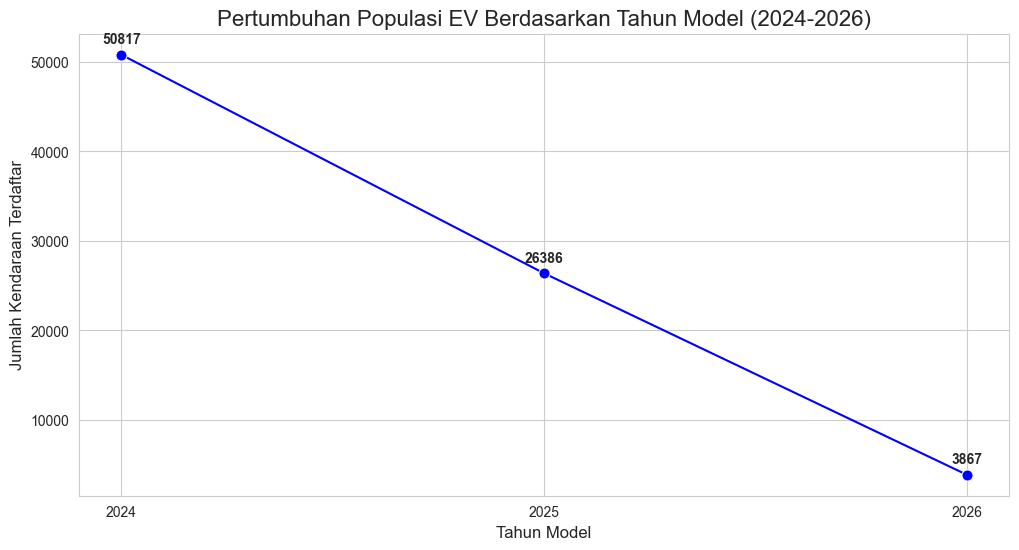

In [23]:
# Menghitung jumlah kendaraan per tahun model
ev_growth = df_cleaned['Model Year'].value_counts().sort_index()

# Membuat visualisasi
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=ev_growth.index, y=ev_growth.values, marker='o', markersize=8, color='b')
plt.title('Pertumbuhan Populasi EV Berdasarkan Tahun Model (2024-2026)', fontsize=16)
plt.xlabel('Tahun Model', fontsize=12)
plt.ylabel('Jumlah Kendaraan Terdaftar', fontsize=12)
plt.xticks(ev_growth.index) # Memastikan semua tahun ditampilkan

# Loop untuk menambahkan label angka di setiap titik
for index, value in ev_growth.items():
    plt.text(index, value + 900, f'{value}',
             ha='center', # Horizontal alignment
             va='bottom', # Vertical alignment
             fontsize=10,
             fontweight='bold')

plt.show()

#### Interpretasi Grafik
Grafik menunjukkan tren penurunan drastis pada jumlah kendaraan listrik (EV) yang terdaftar berdasarkan tahun model dari 2024 hingga 2026.

Puncak Adopsi di Tahun 2024: Jumlah pendaftaran mencapai puncaknya pada tahun 2024 dengan 50,817 unit. Ini menunjukkan basis adopsi yang sangat kuat untuk model tahun tersebut.

Penurunan Signifikan: Angka ini kemudian turun hampir setengahnya pada tahun 2025 menjadi 26,386 unit, dan anjlok lebih jauh pada tahun 2026 menjadi hanya 3,867 unit.

#### Analisis Penyebab Penurunan 
Penurunan ini kemungkinan besar bukan berarti minat pasar menurun, melainkan karena data untuk tahun yang lebih baru belum lengkap. Ini adalah poin analisis yang sangat penting.

Dataset ini kemungkinan besar dikumpulkan pada suatu titik waktu tertentu (misalnya, akhir tahun 2025 atau awal 2026).

Akibatnya, pendaftaran untuk mobil model tahun 2025 belum selesai sepenuhnya, dan pendaftaran untuk mobil model tahun 2026 baru saja dimulai. Oleh karena itu, jumlahnya terekam jauh lebih sedikit.

### **2. Pabrikan dan model EV manakah yang mendominasi pasar pada periode ini?**

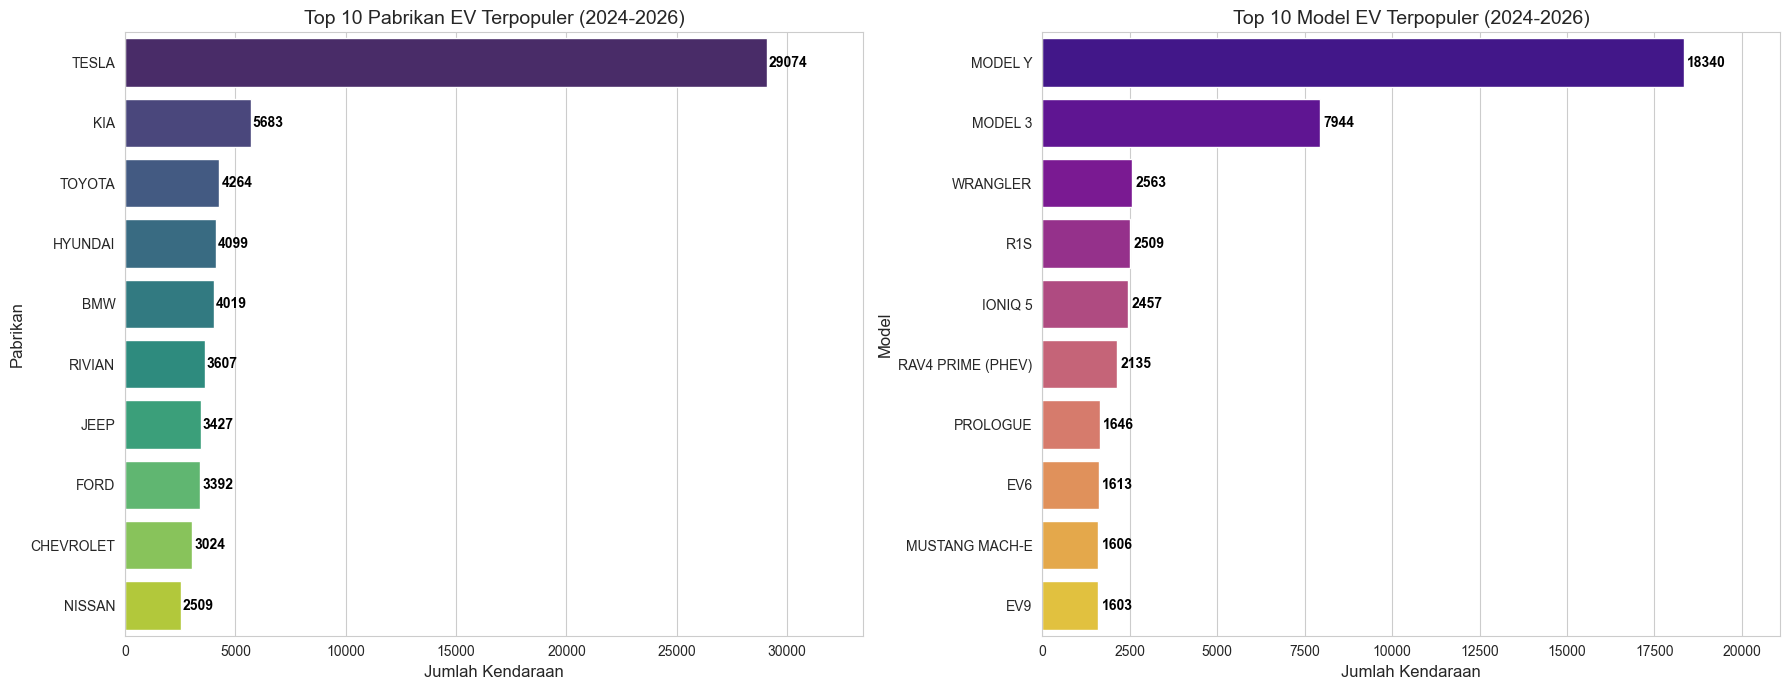

In [31]:
# 10 pabrikan teratas
top_makes = df_cleaned['Make'].value_counts().nlargest(10)

# 10 model teratas
top_models = df_cleaned['Model'].value_counts().nlargest(10)

# Membuat visualisasi
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Grafik untuk Pabrikan ---
ax1 = sns.barplot(
    x=top_makes.values, 
    y=top_makes.index, 
    ax=axes[0], 
    palette='viridis',
    hue=top_makes.index,
    legend=False
)
ax1.set_title('Top 10 Pabrikan EV Terpopuler (2024-2026)', fontsize=14)
ax1.set_xlabel('Jumlah Kendaraan', fontsize=12)
ax1.set_ylabel('Pabrikan', fontsize=12)

# Menambahkan label secara manual untuk setiap bar
for i, v in enumerate(top_makes.values):
    ax1.text(v + 100, i, str(v), color='black', va='center', fontweight='bold')

# --- Grafik untuk Model ---
ax2 = sns.barplot(
    x=top_models.values, 
    y=top_models.index, 
    ax=axes[1], 
    palette='plasma',
    hue=top_models.index,
    legend=False
)
ax2.set_title('Top 10 Model EV Terpopuler (2024-2026)', fontsize=14)
ax2.set_xlabel('Jumlah Kendaraan', fontsize=12)
ax2.set_ylabel('Model', fontsize=12)

# Menambahkan label secara manual untuk setiap bar
for i, v in enumerate(top_models.values):
    ax2.text(v + 100, i, str(v), color='black', va='center', fontweight='bold')

# Menyesuaikan batas sumbu x agar ada ruang untuk label
axes[0].set_xlim(right=top_makes.values.max() * 1.15)
axes[1].set_xlim(right=top_models.values.max() * 1.15)

plt.tight_layout()
plt.show()

#### Interpretasi Grafik 
1. Top 10 Pabrikan EV Terpopuler (2024-2026)
Grafik ini menunjukkan dominasi pasar yang jelas oleh beberapa pabrikan utama dalam periode 2024-2026.

**- Dominasi Mutlak TESLA:** TESLA adalah pemimpin pasar yang tidak tertandingi dengan total 22,971 kendaraan terdaftar. Angka ini lebih dari tiga kali lipat jumlah pesaing terdekatnya, menunjukkan kekuatan merek dan kepercayaan konsumen yang sangat tinggi.

**- Pesaing Papan Atas:** CHEVROLET dan FORD menempati posisi kedua dan ketiga dengan masing-masing 6,420 dan 4,386 kendaraan. Ini menandakan bahwa pabrikan mobil tradisional Amerika telah berhasil mengamankan posisi yang kuat di pasar EV.

**- Pemain Menengah yang Kompetitif:** Pabrikan seperti KIA (2,763), HYUNDAI (2,159), JEEP (2,058), dan VOLKSWAGEN (1,845) membentuk kelompok pesaing yang solid di tingkat menengah. Angka mereka yang relatif berdekatan menunjukkan persaingan yang ketat di segmen ini.

**- Pendatang Baru dan Lainnya:** RIVIAN (1,791), sebagai merek yang lebih baru dan fokus pada EV, berhasil masuk ke 10 besar, menunjukkan penerimaan pasar yang baik. BMW dan TOYOTA melengkapi daftar ini.

2. Top 10 Model EV Terpopuler (2024-2026)
Grafik model menegaskan kembali tren yang terlihat pada grafik pabrikan, dengan beberapa model spesifik yang menjadi pendorong utama penjualan.

**- Duopoli Model Tesla:** Sesuai dengan dominasi pabrikannya, MODEL Y (10,883) dan MODEL 3 (6,948) dari Tesla menempati dua posisi teratas dengan selisih yang sangat besar. Kedua model ini sendiri menyumbang sebagian besar penjualan Tesla.

**- Model Populer Lainnya:** CHEVROLET Bolt EV (2,987) dan EUV (2,279) mengamankan posisi yang kuat, menunjukkan keberhasilan Chevrolet dalam menawarkan alternatif yang kompetitif.

**- Keberagaman Model:** Daftar ini juga menampilkan keberagaman tipe kendaraan, mulai dari SUV seperti Ford Mustang Mach-E (1,768) dan Volkswagen ID.4 (1,514), hingga truk seperti RIVIAN R1S (1,159) dan mobil hybrid populer seperti Jeep Wrangler (2,058).

**Jadi,** Pasar EV pada periode 2024-2026 sangat terkonsentrasi pada TESLA, terutama didorong oleh kesuksesan Model Y dan Model 3. Meskipun demikian, pabrikan tradisional seperti Chevrolet dan Ford telah berhasil membangun pijakan yang kuat dengan model-model populer mereka. Keberadaan berbagai jenis kendaraan (SUV, truk, hybrid) dalam 10 besar menunjukkan bahwa pasar terus berkembang dan terdiversifikasi.

### **3. Bagaimana distribusi geografis populasi EV di 10 kabupaten teratas?**

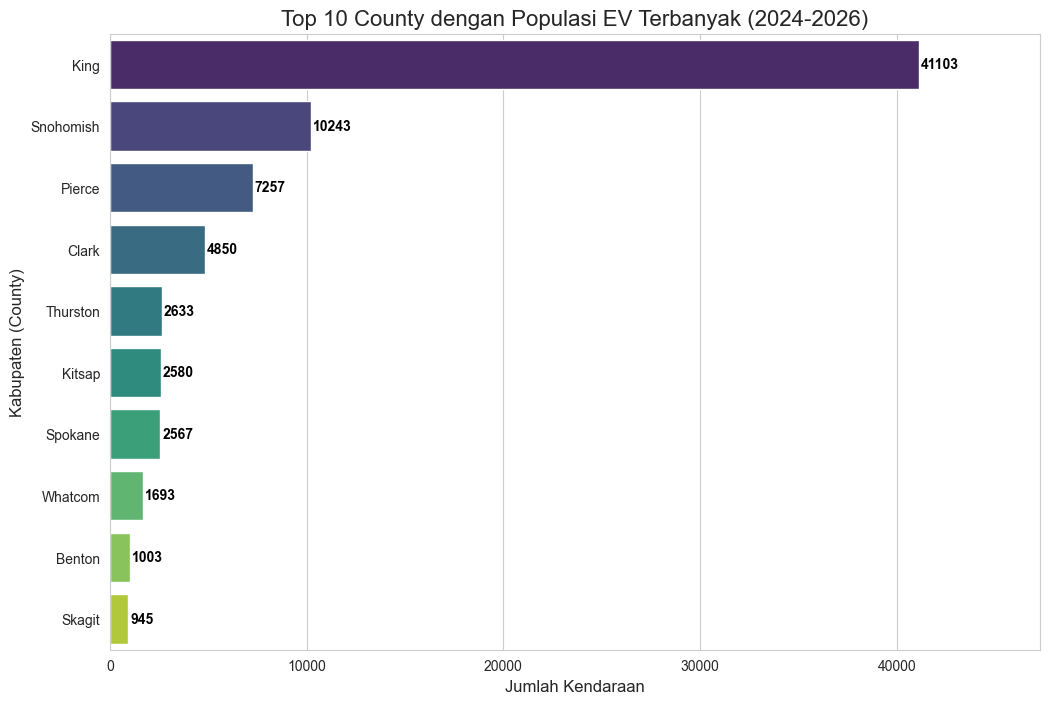

In [35]:
# Menghitung 10 Kabupaten/Kota teratas
top_counties = df_cleaned['County'].value_counts().nlargest(10)

# Membuat visualisasi
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=top_counties.values, 
    y=top_counties.index, 
    palette='viridis',
    hue=top_counties.index, # <-- Perbaikan untuk menghilangkan warning
    legend=False
)
plt.title('Top 10 County dengan Populasi EV Terbanyak (2024-2026)', fontsize=16)
plt.xlabel('Jumlah Kendaraan', fontsize=12)
plt.ylabel('Kabupaten (County)', fontsize=12)

# Menambahkan label secara manual untuk setiap bar
for i, v in enumerate(top_counties.values):
    ax.text(v + 100, i, str(v), color='black', va='center', fontweight='bold')

# Menyesuaikan batas sumbu x agar ada ruang untuk label
plt.xlim(right=top_counties.values.max() * 1.15)

plt.show()

#### Interpretasi Grafik
Grafik ini menampilkan 10 County (Kabupaten) teratas dengan populasi kendaraan listrik (EV) terbanyak untuk model tahun 2024-2026.

1. Dominasi King County: Wilayah King menunjukkan dominasi yang sangat signifikan dengan jumlah kendaraan listrik mencapai 22,971 unit. Angka ini lebih dari tiga kali lipat jumlah populasi di wilayah peringkat kedua, menandakan King County sebagai pusat utama adopsi EV.

2. Kesenjangan yang Jelas: Terdapat kesenjangan yang besar antara peringkat pertama dan peringkat kedua, yaitu Snohomish dengan 6,420 unit. Ini menunjukkan bahwa adopsi EV sangat terkonsentrasi di satu wilayah utama.

3. Distribusi Peringkat Menengah: Wilayah lain seperti Pierce (4,386 unit), Clark (2,763 unit), dan Thurston (2,159 unit) menunjukkan jumlah adopsi yang lebih moderat. Sisa dari 10 besar memiliki populasi di bawah 2,000 unit.


4. Pusat Adopsi (Hub): King County adalah hub atau pusat utama adopsi EV. Ini kemungkinan besar disebabkan oleh faktor-faktor seperti infrastruktur pengisian daya yang lebih matang, insentif lokal yang kuat, atau tingkat pendapatan penduduk yang mendukung.

5. Peluang Pertumbuhan: Wilayah di luar King County, terutama yang berada di peringkat 2 hingga 5 (Snohomish, Pierce, Clark), merupakan area dengan potensi pertumbuhan yang besar. Kebijakan yang menargetkan peningkatan infrastruktur atau sosialisasi di wilayah-wilayah ini dapat secara efektif meningkatkan jumlah adopsi EV secara keseluruhan di negara bagian tersebut.

### 4. Bagaimana proporsi berbagai Jenis Kendaraan Listrik (BEV vs. PHEV)?


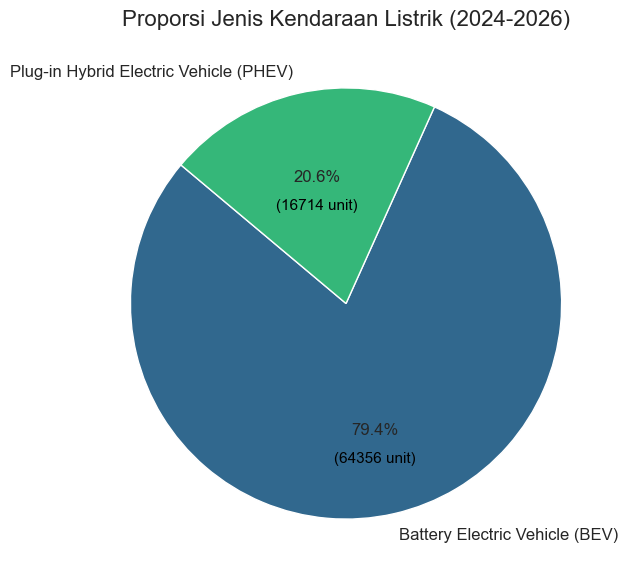

In [37]:
ev_type_counts = df_cleaned['Electric Vehicle Type'].value_counts()


# 1. Tentukan jumlah warna yang dibutuhkan
n_colors = len(ev_type_counts)
# 2. Buat palet warna 'viridis' dari seaborn sejumlah yang kita butuhkan
color_palette = sns.color_palette('viridis', n_colors)
# -----------------------------------------

plt.figure(figsize=(10, 7))
patches, texts, autotexts = plt.pie(
    ev_type_counts, 
    labels=ev_type_counts.index, 
    autopct='%1.1f%%',
    startangle=140, 
    colors=color_palette, # <-- Menggunakan palet warna yang sudah dibuat
    textprops={'fontsize': 12}
)

# Menambahkan label angka spesifik (jumlah) di bawah persentase
for i, patch in enumerate(patches):
    # Mendapatkan posisi teks persentase
    x, y = autotexts[i].get_position()
    # Menambahkan teks baru (jumlah absolut) di bawahnya
    count = ev_type_counts.iloc[i]
    plt.text(x, y-0.1, f'({count} unit)', ha='center', va='top', fontsize=11, color='black')

plt.title('Proporsi Jenis Kendaraan Listrik (2024-2026)', fontsize=16)
plt.ylabel('') # Menghilangkan label y
plt.show()

#### Interpretasi Proporsi Jenis Kendaraan Listrik 
Grafik pie chart ini menunjukkan pembagian pasar antara dua jenis utama kendaraan listrik untuk model tahun 2024-2026.

**Dominasi BEV:** Battery Electric Vehicle (BEV), yang merupakan kendaraan listrik murni, secara jelas mendominasi pasar dengan porsi sebesar 79.5% atau sebanyak 32,238 unit. Ini menunjukkan bahwa mayoritas konsumen lebih memilih solusi kendaraan tanpa emisi sama sekali.

**Porsi PHEV:** Plug-in Hybrid Electric Vehicle (PHEV), yang memiliki mesin bensin sebagai cadangan selain motor listrik, mencakup 20.5% sisanya, atau sebanyak 8,312 unit. Meskipun menjadi minoritas, angka ini tetap signifikan dan menunjukkan bahwa masih ada segmen pasar yang memilih fleksibilitas kendaraan hybrid.

## Statistik Deskriptif

### 5. Apa saja ukuran tendensi sentral dan dispersi (rata-rata, median, standar deviasi) untuk 'Jangkauan Listrik' (Electric Range) kendaraan?


## Statistik Inferensial

### 6. Apakah ada perbedaan yang signifikan secara statistik dalam rata-rata 'Jangkauan Listrik' antara 2 pabrikan kendaraan teratas?

## Time Series Forecasting

### 7.  Berdasarkan data adopsi historis menurut tahun model, dapatkah kita meramalkan pertumbuhan populasi EV untuk 5 tahun ke depan?